# Imports

In [1]:
# Core libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets

# Data manipulation and visualization
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Machine learning utilities
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Progress tracking and utilities
from tqdm import tqdm
import time
import os
import warnings
import shutil
import random
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
print(f"PyTorch version: {torch.__version__}")
print("Setup complete!")

c:\Users\n4400\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Using device: cpu
PyTorch version: 2.9.0+cpu
Setup complete!


# Preprocessing

## Data download

In [ ]:
# Download latest version
pest_path = kagglehub.dataset_download("rupankarmajumdar/crop-pests-dataset")
print(pest_path)

train_path = os.path.join(pest_path, "train", "images")
valid_path = os.path.join(pest_path, "valid", "images")
test_path = os.path.join(pest_path, "test", "images")

# --- INPUT FOLDERS ---
source_folders = [
    train_path,
    valid_path,
    test_path
]

# --- OUTPUT ROOT (everything goes here) ---
dest_path = pest_path
n = 4  # Number of levels to go up
for _ in range(n):
    dest_path = os.path.dirname(dest_path)

destination_root = os.path.join(dest_path, "Combined_DS", "images")

# All possible classes (case-insensitive)
CLASSES = [
    "Ants", "Bees", "Beetle", "Catterpillar", "Earthworms",
    "Earwig", "Grasshopper", "Moth", "Slug", "Snail",
    "Wasp", "Weevil", "Healthy"
]

# Make lookup in lowercase
CLASS_LOOKUP = {cls.lower(): cls for cls in CLASSES}

# Ensure destination folders exist
for cls in CLASSES:
    os.makedirs(os.path.join(destination_root, cls), exist_ok=True)

def get_class_from_filename(filename):
    """
    Extract class from filename like:
    ants-17-_jpg.rf.366ce3d542821626b2926e3142d1bb64
    Returns canonical class name (e.g. 'Ants')
    """
    prefix = filename.split("-")[0].lower()
    return CLASS_LOOKUP.get(prefix, None)

# Process all folders
for src in source_folders:
    if not os.path.isdir(src):
        print(f"Skipping missing folder: {src}")
        continue

    for fname in os.listdir(src):
        if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        cls = get_class_from_filename(fname)
        src_path = os.path.join(src, fname)

        if cls is None:
            print(f"⚠️ Could not determine class for: {fname}")
            continue

        dst_path = os.path.join(destination_root, cls, fname)

        shutil.copy2(src_path, dst_path)   # or use move: shutil.move()
        


# Add Healthy class images

# path to your crop folders (Wheat, Corn, etc.)
healthy_path = kagglehub.dataset_download("mdwaquarazam/agricultural-crops-image-classification")
crop_root =  os.path.join(healthy_path, "Agricultural-crops")

# where your classification dataset is
output_class = os.path.join(destination_root, "Healthy")

for crop_folder in os.listdir(crop_root):
    crop_path = os.path.join(crop_root, crop_folder)
    
    if not os.path.isdir(crop_path):
        continue

    for img in tqdm(os.listdir(crop_path), desc=f"Merging {crop_folder}"):
        if img.lower().endswith((".jpg", ".png", ".jpeg")):
            src = os.path.join(crop_path, img)
            dst = os.path.join(output_class, f"{crop_folder}_{img}")
            shutil.copy(src, dst)

print("✔ All images collected into ../images/ by category.")



C:\Users\n4400\.cache\kagglehub\datasets\rupankarmajumdar\crop-pests-dataset\versions\2
Moved ants-1-_jpg.rf.8227b4d5f1cbbd72c290c1ca6012a337.jpg → Ants/
Moved ants-1-_jpg.rf.cb38695892dc2ca4d3ee97d3f8a06ba7.jpg → Ants/
Moved ants-1-_jpg.rf.ef0ce7e104418cd6d0e0f57c45de1f35.jpg → Ants/
Moved ants-1-_png.rf.0b5a6cf9f49f735808979cd685d8ce4f.jpg → Ants/
Moved ants-1-_png.rf.809de1265776e6576f1633d8656dda40.jpg → Ants/
Moved ants-1-_png.rf.e4e6047152ea7ab2d012b00013d1029e.jpg → Ants/
Moved ants-100-_jpg.rf.7d5b8b923da794ecaaa1a84d9b8dd789.jpg → Ants/
Moved ants-100-_jpg.rf.ca94e096859f9330f96813c0c020330c.jpg → Ants/
Moved ants-100-_jpg.rf.fba81bc6f3a4c080a5f4b22bcb73383f.jpg → Ants/
Moved ants-101-_jpg.rf.04e75ee8d457d15337203d161c334570.jpg → Ants/
Moved ants-101-_jpg.rf.6bab3dd181287ef7dc0a4a44bfc05a2f.jpg → Ants/
Moved ants-101-_jpg.rf.c1ec76e573593e453cb3f2adbc823ff7.jpg → Ants/
Moved ants-103-_jpg.rf.0f06aa6c5b96ce43597a92976ac1577e.jpg → Ants/
Moved ants-103-_jpg.rf.22c551d302fc4fff0

Merging wheat: 100%|██████████| 31/31 [00:00<00:00, 666.95it/s]

✔ All images collected into ../images/ by category.


In [ ]:


# # class names from yaml
# names = [
#     "Ants", "Bees", "Beetles", "Caterpillars", "Earthworms", "Earwigs",
#     "Grasshoppers", "Moths", "Slugs", "Snails", "Wasps", "Weevils"
# ]


# def convert_split(split_path):
#     img_dir = os.path.join(split_path, "images")
#     label_dir = os.path.join(split_path, "labels")

#     # create output root folder (next to the split directory)
#     out_dir = split_path + "_class"

#     # make class subfolders
#     for name in names:
#         os.makedirs(os.path.join(out_dir, name), exist_ok=True)

#     for img in tqdm(os.listdir(img_dir)):
#         if not img.lower().endswith((".jpg", ".jpeg", ".png")):
#             continue

#         stem = img.rsplit(".", 1)[0]
#         label_file = f"{label_dir}/{stem}.txt"

#         # if no label → skip
#         if not os.path.exists(label_file):
#             continue

#         # read the first class id (classification)
#         with open(label_file, "r") as f:
#             first_line = f.readline().strip()
#             if first_line == "":
#                 continue
#             class_id = int(first_line.split()[0])

#         # move image
#         src = f"{img_dir}/{img}"
#         dst = f"{out_dir}/{names[class_id]}/{img}"

#         shutil.copy(src, dst)

#     print(f"Done converting {split_path} → {out_dir}")
#     return out_dir

# print(path)
# train_path = convert_split(os.path.join(path, "train"))
# valid_path = convert_split(os.path.join(path, "valid"))
# test_path = convert_split(os.path.join(path, "test"))


C:\Users\n4400\.cache\kagglehub\datasets\rupankarmajumdar\crop-pests-dataset\versions\2


100%|██████████| 11502/11502 [02:42<00:00, 70.70it/s]


Done converting C:\Users\n4400\.cache\kagglehub\datasets\rupankarmajumdar\crop-pests-dataset\versions\2\train → C:\Users\n4400\.cache\kagglehub\datasets\rupankarmajumdar\crop-pests-dataset\versions\2\train_class


100%|██████████| 1095/1095 [00:15<00:00, 68.93it/s]


Done converting C:\Users\n4400\.cache\kagglehub\datasets\rupankarmajumdar\crop-pests-dataset\versions\2\valid → C:\Users\n4400\.cache\kagglehub\datasets\rupankarmajumdar\crop-pests-dataset\versions\2\valid_class


100%|██████████| 546/546 [00:08<00:00, 66.75it/s]

Done converting C:\Users\n4400\.cache\kagglehub\datasets\rupankarmajumdar\crop-pests-dataset\versions\2\test → C:\Users\n4400\.cache\kagglehub\datasets\rupankarmajumdar\crop-pests-dataset\versions\2\test_class


In [ ]:


# path = kagglehub.dataset_download("rupankarmajumdar/crop-pests-dataset")
# path_healthy = kagglehub.dataset_download("mdwaquarazam/agricultural-crops-image-classification")
# # -----------------------------------------------
# # CONFIG
# # -----------------------------------------------

# # Original dataset paths (already split into train/valid/test)
# SRC_TRAIN = train_path
# SRC_VALID = valid_path
# SRC_TEST = test_path

# # New "Healthy" category images (from multiple subfolders)
# HEALTHY_SRC = os.path.join(path_healthy, "Agricultural-crops")

# DST_ROOT = r"C:\Users\n4400\.cache\kagglehub\datasets\Combined_DS\Images"

# # List of categories
# CLASS_NAMES = [
#     "Ants", "Bees", "Beetles", "Caterpillars", "Earthworms", "Earwigs",
#     "Grasshoppers", "Moths", "Slugs", "Snails", "Wasps", "Weevils",
#     "Healthy"
# ]

# IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".tif", ".webp")


# # --------------------------------------
# # HELPERS
# # --------------------------------------

# def create_class_dirs():
#     os.makedirs(DST_ROOT, exist_ok=True)
#     for cls in CLASS_NAMES:
#         os.makedirs(os.path.join(DST_ROOT, cls), exist_ok=True)


# def copy_images_from_split(split_root):
#     """
#     Copies images from train/valid/test folder structure.
#     Assumes: split_root/<class_name>/*.jpg
#     """
#     for cls in CLASS_NAMES[:-1]:  # exclude Healthy
#         cls_src = os.path.join(split_root, cls)
#         cls_dst = os.path.join(DST_ROOT, cls)

#         if not os.path.isdir(cls_src):
#             continue

#         for img in os.listdir(cls_src):
#             src_img = os.path.join(cls_src, img)
#             if os.path.isfile(src_img) and img.lower().endswith(IMG_EXTS):
#                 shutil.copy2(src_img, cls_dst)


# def copy_healthy_images():
#     """Recursively copy images from HEALTHY_SRC into Healthy folder."""
#     healthy_dst = os.path.join(DST_ROOT, "Healthy")

#     for root, dirs, files in os.walk(HEALTHY_SRC):
#         for img in files:
#             if img.lower().endswith(IMG_EXTS):
#                 src_img = os.path.join(root, img)
#                 dst_img = os.path.join(healthy_dst, img)
#                 shutil.copy2(src_img, dst_img)


# # --------------------------------------
# # MAIN
# # --------------------------------------

# create_class_dirs()

# # Gather training/validation/testing images into the ONE destination folder
# copy_images_from_split(SRC_TRAIN)
# copy_images_from_split(SRC_VALID)
# copy_images_from_split(SRC_TEST)

# # Add Healthy class images
# # path to your crop folders (Wheat, Corn, etc.)
# crop_root =  os.path.join(path_healthy, "Agricultural-crops")

# # where your classification dataset is
# output_class = os.path.join(DST_ROOT, "Healthy")

# for crop_folder in os.listdir(crop_root):
#     crop_path = os.path.join(crop_root, crop_folder)
    
#     if not os.path.isdir(crop_path):
#         continue

#     for img in tqdm(os.listdir(crop_path), desc=f"Merging {crop_folder}"):
#         if img.lower().endswith((".jpg", ".png", ".jpeg")):
#             src = os.path.join(crop_path, img)
#             dst = os.path.join(output_class, f"{crop_folder}_{img}")
#             shutil.copy(src, dst)

# print("✔ All images collected into ../images/ by category.")


Merging wheat: 100%|██████████| 31/31 [00:00<00:00, 666.14it/s]

✔ All images collected into ../images/ by category.


In [3]:
# Split into train test valid

SOURCE_ROOT = destination_root     # all images organized into class folders
DEST_ROOT   = os.path.join(dest_path, "Combined_DS", "dataset")     # final dataset with train/val/test

# train/val/test split ratios
TRAIN_SPLIT = 0.70
VAL_SPLIT   = 0.15
TEST_SPLIT  = 0.15

# ensure repeatability (optional)
random.seed(42)

IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp")


# --------------------------------------
# HELPERS
# --------------------------------------

def make_dirs():
    """Create train/val/test/class subfolders."""
    for split in ["train", "val", "test"]:
        for cls in os.listdir(SOURCE_ROOT):
            os.makedirs(os.path.join(DEST_ROOT, split, cls), exist_ok=True)


def split_data():
    """Split each class folder into 70/15/15 and copy."""
    for cls in os.listdir(SOURCE_ROOT):
        cls_path = os.path.join(SOURCE_ROOT, cls)
        if not os.path.isdir(cls_path):
            continue

        images = [f for f in os.listdir(cls_path) if f.lower().endswith(IMG_EXTS)]
        random.shuffle(images)

        n = len(images)
        n_train = int(n * TRAIN_SPLIT)
        n_val   = int(n * VAL_SPLIT)
        # rest → test
        n_test  = n - n_train - n_val

        train_imgs = images[:n_train]
        val_imgs   = images[n_train:n_train+n_val]
        test_imgs  = images[n_train+n_val:]

        # copy images
        for img in train_imgs:
            shutil.copy2(
                os.path.join(cls_path, img),
                os.path.join(DEST_ROOT, "train", cls, img)
            )
        for img in val_imgs:
            shutil.copy2(
                os.path.join(cls_path, img),
                os.path.join(DEST_ROOT, "val", cls, img)
            )
        for img in test_imgs:
            shutil.copy2(
                os.path.join(cls_path, img),
                os.path.join(DEST_ROOT, "test", cls, img)
            )

        print(f"✔ {cls}: {n_train} train, {n_val} val, {n_test} test")




# --------------------------------------
# MAIN
# --------------------------------------

make_dirs()
split_data()

print("\n🎉 Dataset successfully split into 70/15/15 train/val/test!")

✔ Ants: 833 train, 178 val, 179 test
✔ Bees: 858 train, 183 val, 185 test
✔ Beetle: 688 train, 147 val, 148 test
✔ Catterpillar: 728 train, 156 val, 157 test
✔ Earthworms: 557 train, 119 val, 121 test
✔ Earwig: 764 train, 163 val, 165 test
✔ Grasshopper: 826 train, 177 val, 177 test
✔ Healthy: 580 train, 124 val, 125 test
✔ Moth: 840 train, 180 val, 181 test
✔ Slug: 650 train, 139 val, 140 test
✔ Snail: 850 train, 182 val, 183 test
✔ Wasp: 816 train, 175 val, 176 test
✔ Weevil: 785 train, 168 val, 169 test

🎉 Dataset successfully split into 70/15/15 train/val/test!


## Data Augmentation

In [4]:
# Define comprehensive data augmentation
print("🎨 Implementing Advanced Data Augmentation")



train_transform = transforms.Compose([
    transforms.Resize((224, 224)),

    # horizontal flip augmentation
    transforms.RandomHorizontalFlip(p=0.5),
    
    # rotation augmentation  
    # HINT: Use transforms.RandomRotation(degrees=10) for ±10 degree rotation
    transforms.RandomRotation(degrees=10),   
    
    # translation augmentation
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  #  
    
    # color jitter augmentation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),   

    # Convert to tensor
    transforms.ToTensor(),   
    
    # random erasing augmentation 
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.25)),   
    
    
    # Normalize with Resnet 18 statistics
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))    
])

# TODO: Create test transforms (no augmentation for consistent evaluation)
# HINT: Test set should only have ToTensor() and Normalize() - no augmentation!
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # TODO: Convert to tensor
    transforms.ToTensor(),   
    
    # TODO: Normalize with same statistics as training
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


try:
    # Create augmented datasets
    train_path = os.path.join(DEST_ROOT, "train")
    valid_path = os.path.join(DEST_ROOT, "val")
    test_path = os.path.join(DEST_ROOT, "test")
    
    train_ds = datasets.ImageFolder(root=train_path, transform=train_transform)

    valid_ds = datasets.ImageFolder(root=valid_path, transform=test_transform)

    test_ds = datasets.ImageFolder(root=test_path, transform=test_transform)
    
    # Test that transforms work
    sample_img, sample_label = train_ds[0]
    
    print(f"✅ SUCCESS! Augmented dataset created")
    print(f"✅ Training transforms: {len([t for t in train_transform.transforms if t is not None])} operations")
    print(f"✅ Test transforms: {len([t for t in test_transform.transforms if t is not None])} operations")
    print(f"✅ Sample image shape: {sample_img.shape}")
    print(f"✅ Sample image range: [{sample_img.min():.3f}, {sample_img.max():.3f}]")


    print(f"Training samples: {len(train_ds):,}")
    print(f"Test samples: {len(test_ds):,}")
    print(f"Image shape: {train_ds[0][0].shape}")
    print(f"Classes: {CLASSES}")

    # Analyze class distribution
    train_labels = [train_ds[i][1] for i in range(len(train_ds))]
    class_counts = np.bincount(train_labels)

    print(f"\n📊 Class Distribution:")
    for i, (class_name, count) in enumerate(zip(CLASSES, class_counts)):
        print(f"   {i}: {class_name:13} - {count:,} samples")
        
    # Validation checks
    if sample_img.shape == (3, 224, 224):
        print("🎯 EXCELLENT! Sample has correct dimensions")
    else:
        print(f"❌ ERROR: Expected (3, 224, 224), got {sample_img.shape}")
        
except Exception as e:
    print(f"❌ Implementation incomplete: {e}")
    print("check path names")


🎨 Implementing Advanced Data Augmentation
✅ SUCCESS! Augmented dataset created
✅ Training transforms: 8 operations
✅ Test transforms: 3 operations
✅ Sample image shape: torch.Size([3, 224, 224])
✅ Sample image range: [-1.758, 2.640]
Training samples: 9,775
Test samples: 2,106
Image shape: torch.Size([3, 224, 224])
Classes: ['Ants', 'Bees', 'Beetle', 'Catterpillar', 'Earthworms', 'Earwig', 'Grasshopper', 'Moth', 'Slug', 'Snail', 'Wasp', 'Weevil', 'Healthy']

📊 Class Distribution:
   0: Ants          - 833 samples
   1: Bees          - 858 samples
   2: Beetle        - 688 samples
   3: Catterpillar  - 728 samples
   4: Earthworms    - 557 samples
   5: Earwig        - 764 samples
   6: Grasshopper   - 826 samples
   7: Moth          - 580 samples
   8: Slug          - 840 samples
   9: Snail         - 650 samples
   10: Wasp          - 850 samples
   11: Weevil        - 816 samples
   12: Healthy       - 785 samples
🎯 EXCELLENT! Sample has correct dimensions


NameError: name 'classes' is not defined

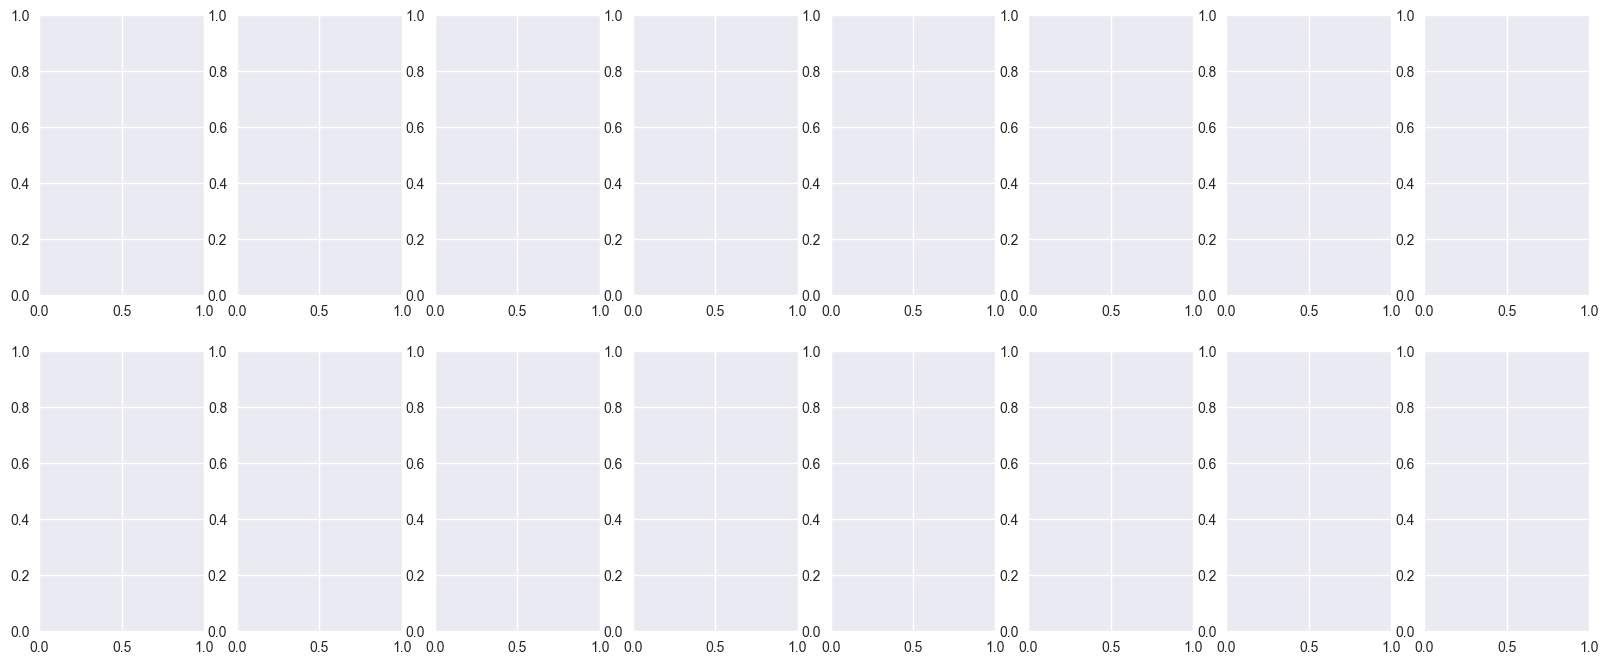

In [5]:
# Visualize augmentation effects
def visualize_augmentation():
    """Show the effect of data augmentation on sample images"""
    
    # Get original image
    original_dataset = valid_ds
    
    # Sample image
    img_idx = 400
    path, label = original_dataset.samples[img_idx]
    pil_img = Image.open(path).convert("RGB")
    pil_img = transforms.Resize((224, 224))(pil_img)
    original_img = transforms.ToTensor()(pil_img)
    
    fig, axes = plt.subplots(2, 8, figsize=(20, 8))
    fig.suptitle(f'Data Augmentation Effects - {classes[label]}', 
                 fontsize=16, fontweight='bold')
    
    # Show original
    axes[0, 0].imshow(original_img.permute(1, 2, 0))
    axes[0, 0].set_title('Original', fontweight='bold')
    axes[0, 0].axis('off')
    
    # TODO: Show augmented versions
    augment_only = transforms.Compose([
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3),
        transforms.ToTensor()
    ])
    
    # Create different augmentation pipelines for visualization
    augmentations = [
        transforms.Compose([transforms.RandomHorizontalFlip(p=1.0), transforms.ToTensor()]),
        transforms.Compose([transforms.RandomRotation(degrees=15), transforms.ToTensor()]),
        transforms.Compose([transforms.ColorJitter(brightness=0.3), transforms.ToTensor()]),
        transforms.Compose([transforms.ColorJitter(contrast=0.3), transforms.ToTensor()]),
        transforms.Compose([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), transforms.ToTensor()]),
        transforms.Compose([transforms.ColorJitter(saturation=0.3), transforms.ToTensor()]),
        transforms.Compose([transforms.ToTensor(), transforms.RandomErasing(p=1.0)])
    ]
    
    aug_names = ['Horizontal Flip', 'Rotation', 'Brightness', 'Contrast', 
                 'Translation', 'Saturation', 'Random Erasing']
    
    # Convert to PIL for augmentation
    pil_img = transforms.ToPILImage()(original_img)
    
    for i, (aug, name) in enumerate(zip(augmentations, aug_names)):
        aug_img = aug(pil_img)
        
        axes[0, i+1].imshow(aug_img.permute(1, 2, 0))
        axes[0, i+1].set_title(name, fontsize=10)
        axes[0, i+1].axis('off')
    
    # Show multiple random augmentations
    full_aug = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor()
    ])
    
    for i in range(8):
        aug_img = full_aug(pil_img)
        axes[1, i].imshow(aug_img.permute(1, 2, 0))
        axes[1, i].set_title(f'Combined Aug {i+1}', fontsize=10)
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_augmentation()


# Model and Training

In [ ]:
# Setup for transfer learning
print("🔄 Setting up Transfer Learning")

def create_pretrained_model(model_name='resnet18', num_classes=13, feature_extract=True):
    """Create a pre-trained model for transfer learning"""
    
    model = None
    
    if model_name == 'resnet18':
        #Load pre-trained ResNet18
        model = models.resnet18(pretrained=True)   
        
        # Freeze parameters for feature extraction
        if feature_extract == True:
            for param in model.parameters(): 
                param.requires_grad = False
            pass
        
        # Replace final layer for CIFAR-10 (10 classes instead of 1000)
        num_features = model.fc.in_features  # Get model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)      # Create new Linear layer
        
    
    return model

# Create different transfer learning approaches

print("🔧 Creating Transfer Learning Models...")

try:
    transfer_models = {
        #  Create ResNet18 with feature extraction
        'ResNet18 Feature Extraction': create_pretrained_model('resnet18', num_classes=13, feature_extract=True),   
        
        # Create ResNet18 with fine-tuning  
        'ResNet18 Fine-tuning': create_pretrained_model('resnet18', num_classes=13, feature_extract=False),   
    }

    # Move models to device and analyze
    print("📊 Transfer Learning Model Analysis:")
    print("=" * 70)
    
    for name, model in transfer_models.items():
        if model is not None:
            model = model.to(device)
            
            # Count trainable vs total parameters
            trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
            total_params = sum(p.numel() for p in model.parameters())
            
            print(f"{name:25} | {trainable_params:>8,} / {total_params:>8,} trainable params")
        else:
            print(f"{name:25} | NOT IMPLEMENTED")

    
except Exception as e:
    print(f"❌  {e}")

🔄 Setting up Transfer Learning
🔧 Creating Transfer Learning Models...
📊 Transfer Learning Model Analysis:
ResNet18 Feature Extraction |    6,669 / 11,183,181 trainable params
ResNet18 Fine-tuning      | 11,183,181 / 11,183,181 trainable params

✅ Transfer learning models created
📝 Key Concepts:
   • Feature Extraction: Only train final layer (faster, less overfitting)
   • Fine-tuning: Train all layers (slower, potentially better performance)
   • Pre-trained models provide learned features from ImageNet


In [ ]:
# Compare transfer learning approaches
print("⚖️ Comparing Transfer Learning Approaches")
print("=" * 50)

# Modified training function for transfer learning
def train_transfer_model(model, train_loader, val_loader, model_name, num_epochs=5):
    """Train transfer learning model with appropriate learning rate"""
    
    # Different learning rates for different approaches
    if 'Feature Extraction' in model_name:
        learning_rate = 0.001  # Higher LR for feature extraction
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    else:
        learning_rate = 0.0001  # Lower LR for fine-tuning
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    criterion = nn.CrossEntropyLoss()
    
    print(f"\n🔄 Training {model_name}")
    print(f"Learning Rate: {learning_rate}, Epochs: {num_epochs}")
    
    history = {'train_acc': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_correct = 0
        train_total = 0
        
        for data, target in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
        
        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()
        
        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total
        
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        print(f"   Epoch {epoch+1}: Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
    
    return history, val_acc

# Train and compare transfer learning models
transfer_results = {}
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(valid_ds, batch_size=32)

# Train each transfer learning approach
for name, model in list(transfer_models.items())[:2]:  # Train first 2 models
    start_time = time.time()
    history, final_acc = train_transfer_model(
        model, train_loader, val_loader, name, num_epochs=5
    )
    training_time = time.time() - start_time
    
    transfer_results[name] = {
        'history': history,
        'final_accuracy': final_acc,
        'training_time': training_time
    }
    
    print(f"   ✅ Completed in {training_time:.1f}s, Final Accuracy: {final_acc:.2f}%")

print(f"\n📊 Transfer Learning Results Summary:")
for name, results in transfer_results.items():
    print(f"   {name}: {results['final_accuracy']:.2f}% in {results['training_time']:.1f}s")

⚖️ Comparing Transfer Learning Approaches

🔄 Training ResNet18 Feature Extraction
Learning Rate: 0.001, Epochs: 5


Epoch 1: 100%|██████████| 306/306 [03:23<00:00,  1.51it/s]


   Epoch 1: Train Acc: 63.60%, Val Acc: 77.92%


Epoch 2: 100%|██████████| 306/306 [05:01<00:00,  1.02it/s]


   Epoch 2: Train Acc: 74.37%, Val Acc: 79.55%


Epoch 3: 100%|██████████| 306/306 [04:21<00:00,  1.17it/s]


   Epoch 3: Train Acc: 76.43%, Val Acc: 83.48%


Epoch 4: 100%|██████████| 306/306 [04:27<00:00,  1.14it/s]


   Epoch 4: Train Acc: 77.72%, Val Acc: 81.61%


Epoch 5: 100%|██████████| 306/306 [04:34<00:00,  1.12it/s]


   Epoch 5: Train Acc: 77.82%, Val Acc: 82.57%
   ✅ Completed in 1558.8s, Final Accuracy: 82.57%

🔄 Training ResNet18 Fine-tuning
Learning Rate: 0.0001, Epochs: 5


Epoch 1: 100%|██████████| 306/306 [08:10<00:00,  1.60s/it]


   Epoch 1: Train Acc: 76.52%, Val Acc: 88.27%


Epoch 2: 100%|██████████| 306/306 [07:04<00:00,  1.39s/it]


   Epoch 2: Train Acc: 88.43%, Val Acc: 90.76%


Epoch 3: 100%|██████████| 306/306 [07:10<00:00,  1.41s/it]


   Epoch 3: Train Acc: 92.42%, Val Acc: 92.72%


Epoch 4: 100%|██████████| 306/306 [06:53<00:00,  1.35s/it]


   Epoch 4: Train Acc: 94.36%, Val Acc: 92.58%


Epoch 5: 100%|██████████| 306/306 [06:48<00:00,  1.34s/it]


   Epoch 5: Train Acc: 95.21%, Val Acc: 93.10%
   ✅ Completed in 2344.5s, Final Accuracy: 93.10%

📊 Transfer Learning Results Summary:
   ResNet18 Feature Extraction: 82.57% in 1558.8s
   ResNet18 Fine-tuning: 93.10% in 2344.5s


In [ ]:
# Implement Grad-CAM for CNN interpretability
class GradCAM:
    """Gradient-weighted Class Activation Mapping"""
    
    def __init__(self, model, target_layer_name):
        self.model = model
        self.target_layer_name = target_layer_name
        self.gradients = None
        self.activations = None
        
        # Register hooks (implemented for you)
        self._register_hooks()
    
    def _register_hooks(self):
        """Register forward and backward hooks"""
        
        def forward_hook(module, input, output):
            self.activations = output
        
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]
        
        # Find target layer and register hooks
        target_layer = dict(self.model.named_modules())[self.target_layer_name]
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)
    
    def generate_cam(self, input_tensor, class_idx=None):
        if not input_tensor.requires_grad:
            input_tensor = input_tensor.clone().detach().requires_grad_(True)

        """Generate Grad-CAM heatmap"""
        
        # Forward pass to get model output
        self.model.eval()
        output = self.model(input_tensor)    
        
        # Get target class index
        if class_idx is None:
            class_idx = torch.argmax(output)   
        
        # TODO: Backward pass to compute gradients
        self.model.zero_grad()

        output[0, class_idx].backward()  
        
        # Compute Grad-CAM using gradients and activations
        
        # Remove batch dimension
        gradients = self.gradients[0]    # Shape: [channels, height, width]
        activations = self.activations[0]  # Shape: [channels, height, width]
        
        # Compute importance weights by global average pooling of gradients
        weights = torch.mean(gradients, dim=(1, 2))    # global average pool
        
        # Compute weighted combination of activation maps
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32)  # [height, width]
        
          
          #- weighted combination
        for i, w in enumerate(weights):
            cam += w * activations[i]  # w * activations[i]
        
        # TODO: Apply ReLU and normalize
        # HINT: Use F.relu(cam) to remove negative values
        # HINT: Normalize by dividing by torch.max(cam) if max > 0
        cam = F.relu(cam)  # Apply ReLU
        if torch.max(cam) > 0:
            cam = cam / torch.max(cam)  # Normalize by max value
        
        return cam.detach().cpu().numpy()


🔍 Testing Grad-CAM Implementation...
⚠️  Grad-CAM requires a trained model to work properly
✅ Grad-CAM class structure implemented
💡 This will be tested after training your model

🧠 Grad-CAM Concept:
   • Grad-CAM shows which image regions influence predictions
   • Uses gradients flowing back to target layer
   • Weights activation maps by their importance
   • Helps understand what the CNN is 'looking at'


# Analysis

🎯 Applying Grad-CAM Analysis...
ResNet18 Feature Extraction


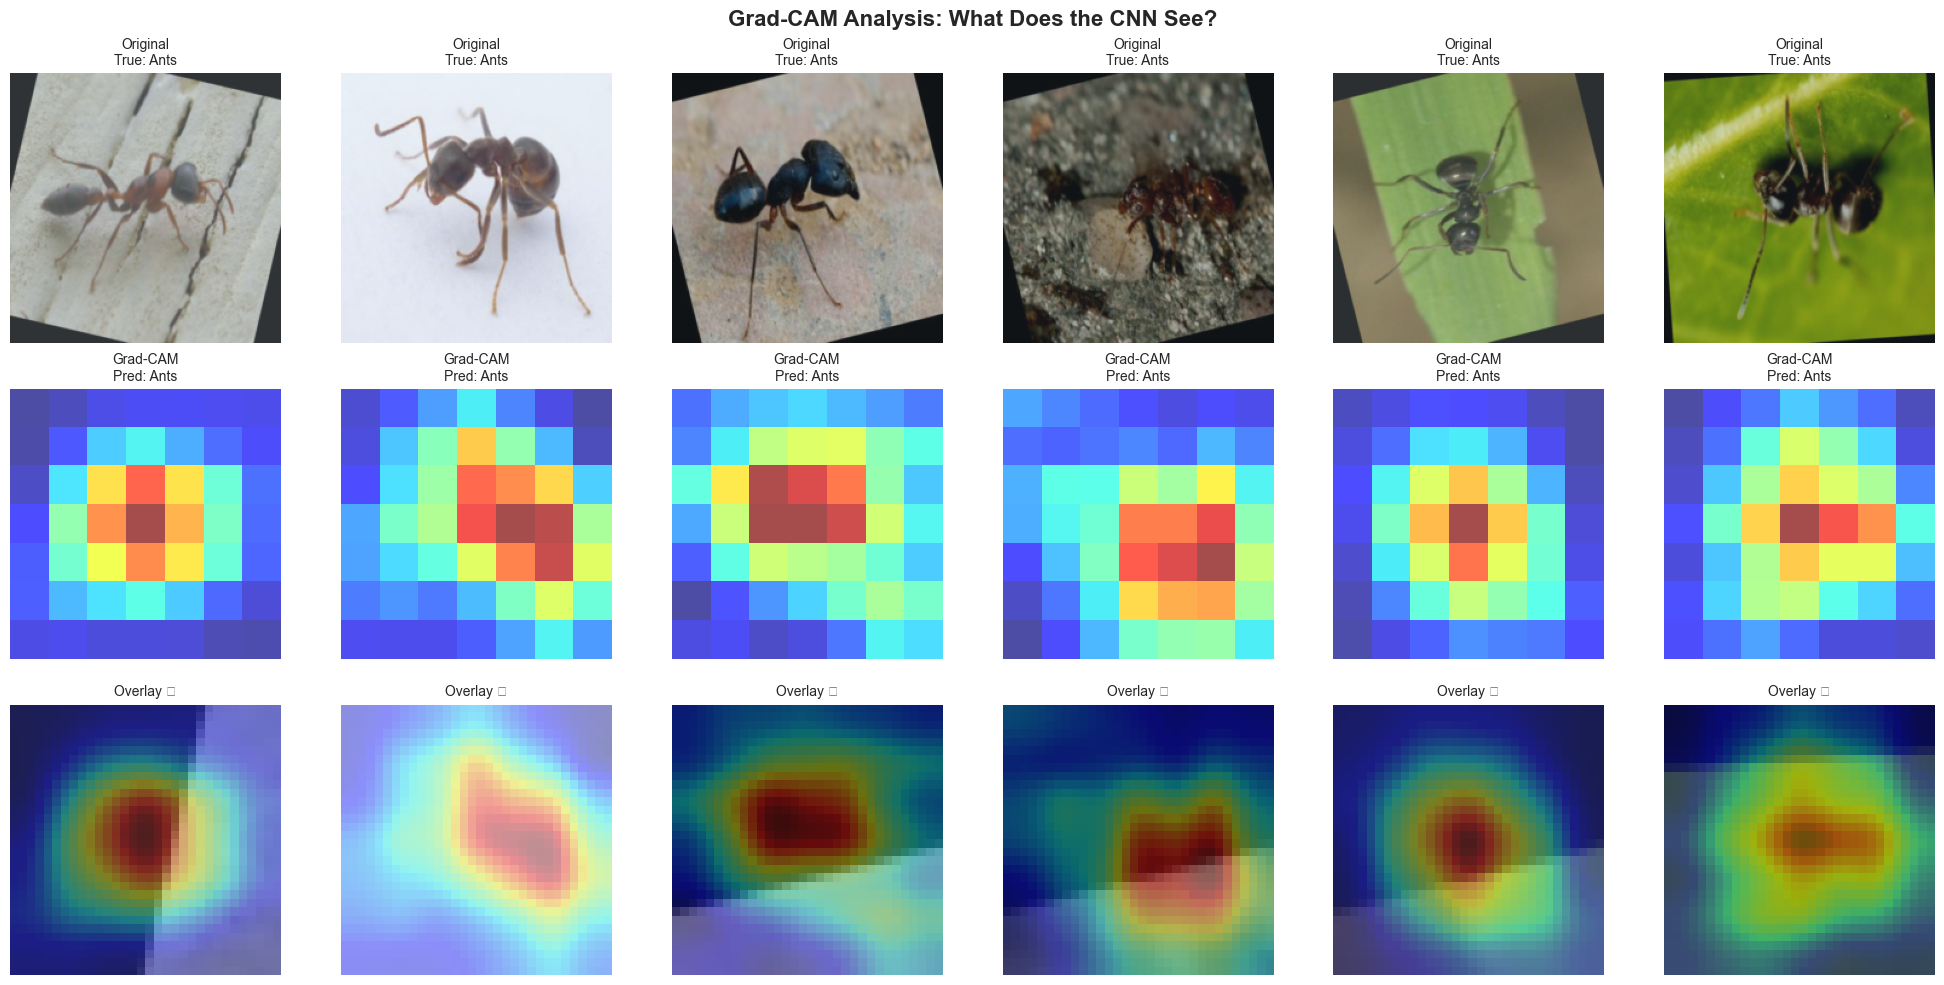


📊 Analysis Results:
   Accuracy on samples: 6/6 (100.0%)
   ✅ Red areas show where the CNN focuses attention
   🔍 Does the model focus on relevant object parts?
ResNet18 Fine-tuning


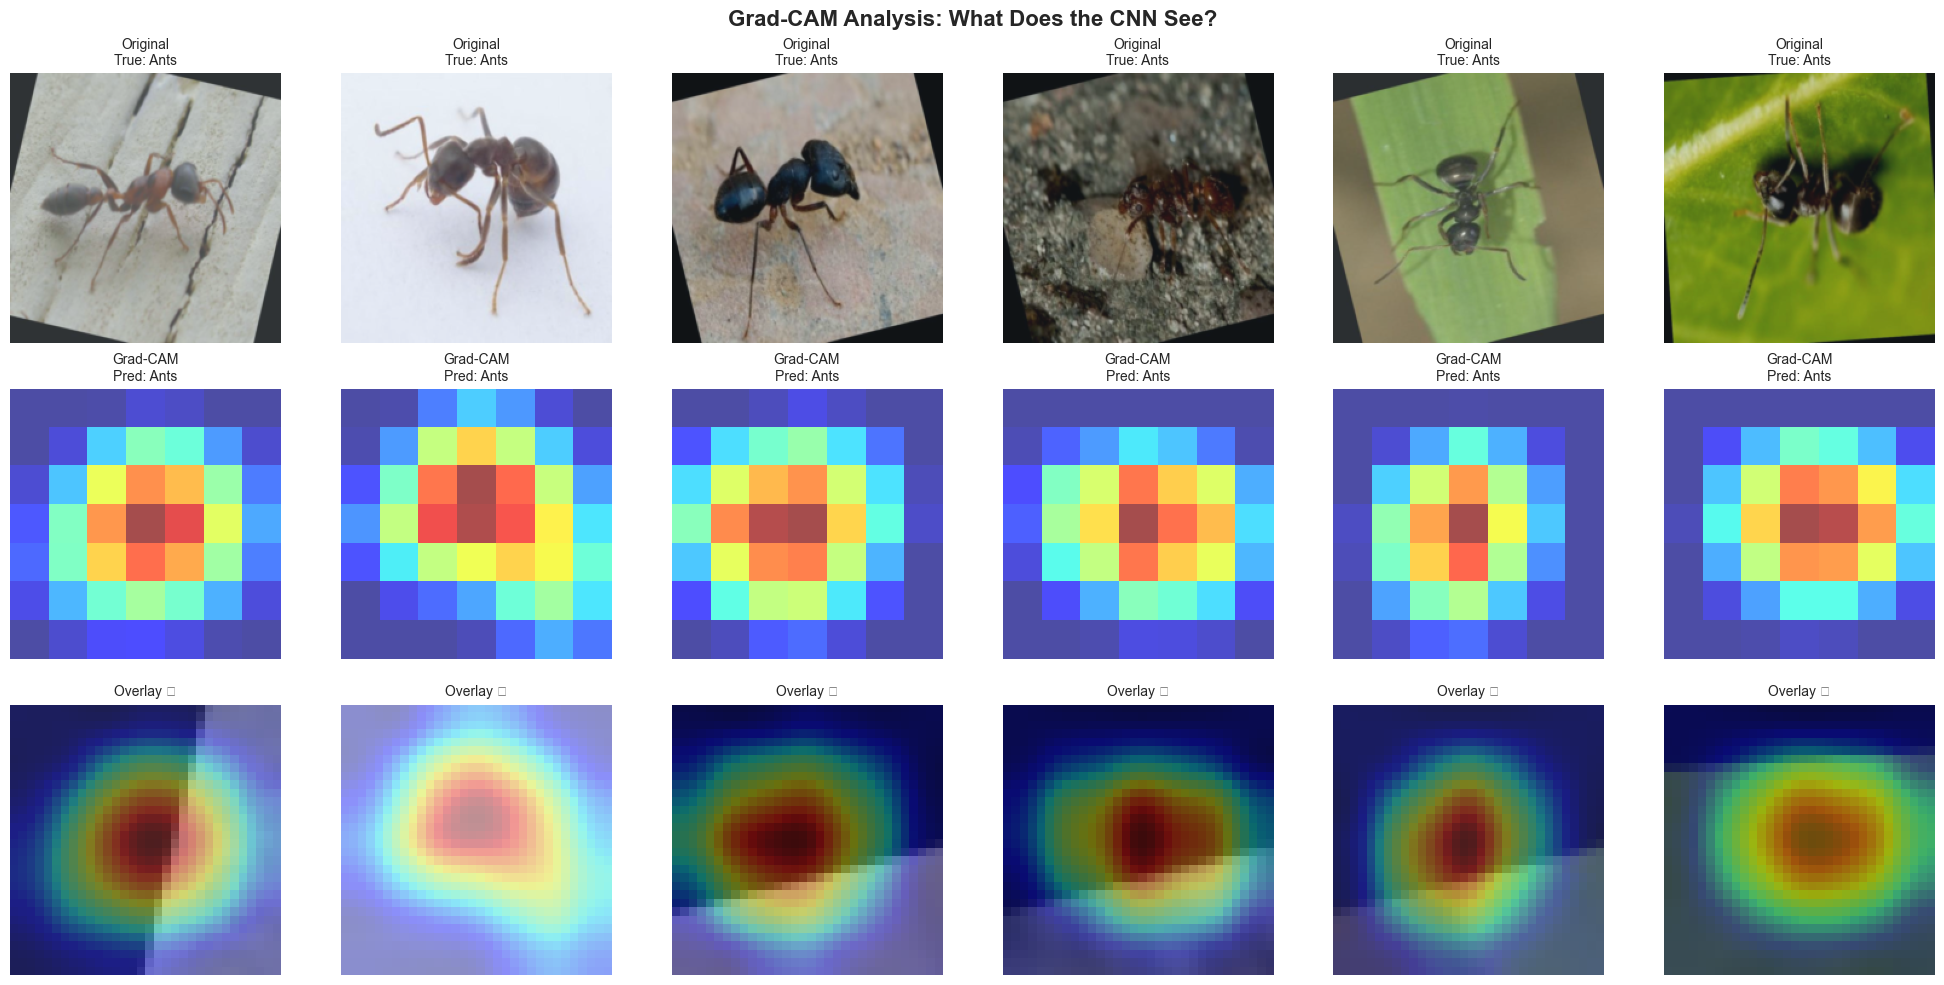


📊 Analysis Results:
   Accuracy on samples: 6/6 (100.0%)
   ✅ Red areas show where the CNN focuses attention
   🔍 Does the model focus on relevant object parts?

🧠 Interpretability Insights:
   • Grad-CAM shows which image regions influence predictions
   • Helps identify if model focuses on relevant features
   • Can reveal biases or shortcut learning
   • Useful for debugging and building trust in AI systems


In [ ]:
# Apply Grad-CAM to analyze model decisions
def visualize_gradcam_results(model, test_loader, num_samples=8):
    """Visualize Grad-CAM results for sample predictions"""
    
    gradcam = GradCAM(model, 'layer4.1.conv2')
    model.eval()
    
    images, labels, predictions, cams = [], [], [], []
    
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        
        for i in range(min(num_samples, data.size(0))):
            if len(images) >= num_samples:
                break
            
            # Get single image
            img = data[i:i+1]
            label = target[i].item()

            # Normal forward pass (no grad)
            with torch.no_grad():
                output = model(img)
                pred = torch.argmax(output, dim=1).item()

            # ✅ Grad-CAM requires gradients: enable them here
            with torch.enable_grad():
                img = img.clone().detach().requires_grad_(True)
                cam = gradcam.generate_cam(img, class_idx=pred)

            # Denormalize image
            img_denorm = img[0].cpu()
            img_denorm = img_denorm * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
            img_denorm = img_denorm + torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
            img_denorm = torch.clamp(img_denorm, 0, 1)
            
            images.append(img_denorm.permute(1, 2, 0).detach().numpy())
            labels.append(label)
            predictions.append(pred)
            cams.append(cam)
        
        if len(images) >= num_samples:
            break

    
    # TODO: Visualize results
    fig, axes = plt.subplots(3, num_samples, figsize=(20, 10))
    fig.suptitle('Grad-CAM Analysis: What Does the CNN See?', fontsize=16, fontweight='bold')
    
    for i in range(num_samples):
        # Original image
        axes[0, i].imshow(images[i])
        axes[0, i].set_title(f'Original\nTrue: {classes[labels[i]]}', fontsize=10)
        axes[0, i].axis('off')
        
        # Grad-CAM heatmap
        im1 = axes[1, i].imshow(cams[i], cmap='jet', alpha=0.7)
        axes[1, i].set_title(f'Grad-CAM\nPred: {classes[predictions[i]]}', fontsize=10)
        axes[1, i].axis('off')
        
        # Overlay
        axes[2, i].imshow(images[i])
        # Resize CAM to match image size
        cam_resized = np.array(Image.fromarray(cams[i]).resize((32, 32)))
        axes[2, i].imshow(cam_resized, cmap='jet', alpha=0.4)
        
        correct = '✓' if labels[i] == predictions[i] else '✗'
        axes[2, i].set_title(f'Overlay {correct}', fontsize=10)
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Analyze results
    correct_predictions = sum(1 for i in range(num_samples) if labels[i] == predictions[i])
    print(f"\n📊 Analysis Results:")
    print(f"   Accuracy on samples: {correct_predictions}/{num_samples} ({100*correct_predictions/num_samples:.1f}%)")
    print(f"   ✅ Red areas show where the CNN focuses attention")
    print(f"   🔍 Does the model focus on relevant object parts?")
    
    return images, labels, predictions, cams


# Apply Grad-CAM analysis
test_loader=DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

print("🎯 Applying Grad-CAM Analysis...")
for name, model in list(transfer_models.items())[:2]:
    print(name)
    gradcam_results = visualize_gradcam_results(model, test_loader, num_samples=6)



ResNet18 Feature Extraction


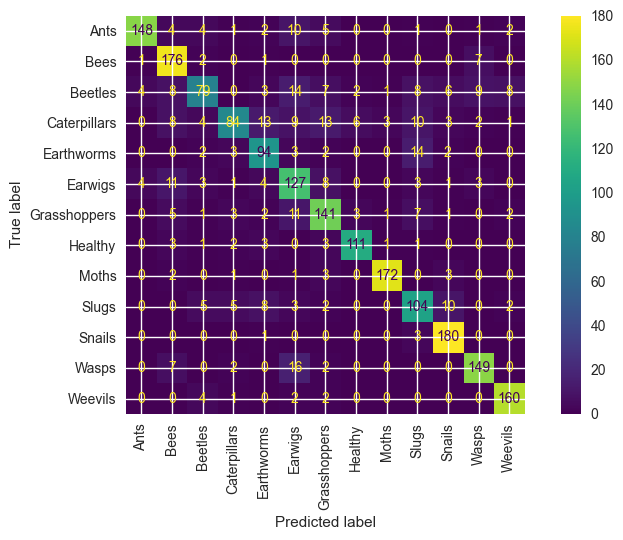

ResNet18 Fine-tuning


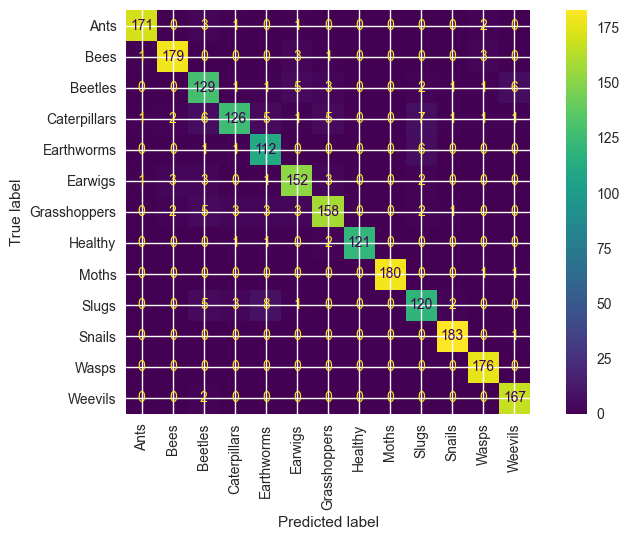

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get Confusion Matrix for each model
for name, model in list(transfer_models.items())[:2]:
    print(name)
    all_preds = []
    all_labels = []

    # Disable gradient tracking during inference
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1) # Get predicted class
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes) # class_names is a list of your class labels
    disp.plot()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [ ]:
# Get accuracy for each model
for name, model in list(transfer_models.items())[:2]:
    model.eval()
    test_correct = 0
    test_total = 0
            
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
                    
            _, predicted = torch.max(output.data, 1)
            test_total += target.size(0)
            test_correct += (predicted == target).sum().item()
            
    
    test_acc = 100. * test_correct / test_total
    print(name)
    print(test_acc)

81.86995728523968
93.68770764119601
